# 分析某个topic下，db数据的变化

In [28]:
import sqlite3
import pandas as pd
import os
import glob

# 修改工作目录到项目根目录
os.chdir("../../")


In [ ]:
topic_index = 2
datetime_name = "20250506_163441"
output_dir = f"visualization/DBinfo/db_analysis/topic_{topic_index}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 获取最新的数据库文件
db_dir = f"simu_db/topic_{topic_index}/{datetime_name}"  # 根据实际路径调整
latest_run = max(os.listdir(db_dir))
db_backups = glob.glob(f"{db_dir}/backups/*.db")
latest_db = max(db_backups, key=os.path.getctime)

## 分析下某次实验的所有表记录数

In [ ]:
analysis_db = db_backups[-3]

print(f"分析数据库: {analysis_db}")

# 连接数据库
conn = sqlite3.connect(analysis_db)

# 获取所有表名
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("\n数据库中的表:")
for table in tables:
    table_name = table[0]
    print(f"\n表名: {table_name}")
    
    # 获取表结构
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    print("列信息:")
    for col in columns:
        print(f"  - {col[1]} ({col[2]})")
    
    # 获取表中的记录数
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    count = cursor.fetchone()[0]
    print(f"记录数: {count}")
conn.close()


tables_name = [table[0] for table in tables]
table_count = pd.DataFrame(columns=[f"{table_name}_count" for table_name in tables_name])

# 根据数字排序db_backups
sorted_db_backups = sorted(db_backups, key=lambda x: int(x.split('_')[-1].split('.')[0]) if x.split('_')[-1].split('.')[0].isdigit() else float('inf'))

for analysis_db in sorted_db_backups:
    analysis_db_name = analysis_db.split("/")[-1]
    table_count.loc[analysis_db_name] = 0
    conn = sqlite3.connect(analysis_db)
    cursor = conn.cursor()
    for table_name in tables_name:
        cursor.execute(f"SELECT * FROM {table_name}")
        data = cursor.fetchall()
        table_count.loc[analysis_db_name, f"{table_name}_count"] = len(data)

table_count.to_csv(f"{output_dir}/table_count_topic_{topic_index}_{datetime_name}.csv", index=True)

分析数据库: simu_db/topic_2/20250506_163441/backups/twitter_simulation_10.db

数据库中的表:

表名: user
列信息:
  - user_id (INTEGER)
  - agent_id (INTEGER)
  - user_name (TEXT)
  - name (TEXT)
  - bio (TEXT)
  - created_at (DATETIME)
  - num_followings (INTEGER)
  - num_followers (INTEGER)
记录数: 111

表名: sqlite_sequence
列信息:
  - name ()
  - seq ()
记录数: 7

表名: post
列信息:
  - post_id (INTEGER)
  - user_id (INTEGER)
  - original_post_id (INTEGER)
  - content (TEXT)
  - quote_content (TEXT)
  - created_at (DATETIME)
  - num_likes (INTEGER)
  - num_dislikes (INTEGER)
  - num_shares (INTEGER)
记录数: 161

表名: follow
列信息:
  - follow_id (INTEGER)
  - follower_id (INTEGER)
  - followee_id (INTEGER)
  - created_at (DATETIME)
记录数: 132

表名: mute
列信息:
  - mute_id (INTEGER)
  - muter_id (INTEGER)
  - mutee_id (INTEGER)
  - created_at (DATETIME)
记录数: 0

表名: like
列信息:
  - like_id (INTEGER)
  - user_id (INTEGER)
  - post_id (INTEGER)
  - created_at (DATETIME)
记录数: 11

表名: dislike
列信息:
  - dislike_id (INTEGER)
  - user_id 

## 分析这个实验下某个时间步的结果

#### 前期统计计算

In [62]:
analysis_db = db_backups[-1]
conn = sqlite3.connect(analysis_db)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# 提取user, post, follow表
user_table = pd.read_sql_query("SELECT * FROM user", conn)
post_table = pd.read_sql_query("SELECT * FROM post", conn)
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
user_table.to_csv(f"{output_dir}/user_table_topic_{topic_index}_{datetime_name}.csv", index=False)
post_table.to_csv(f"{output_dir}/post_table_topic_{topic_index}_{datetime_name}.csv", index=False)
follow_table.to_csv(f"{output_dir}/follow_table_topic_{topic_index}_{datetime_name}.csv", index=False)

user_post_content_map = {}
user_post_like_map = {}
# 遍历post表，将user_id作为key, 找到其所有的posts，并将post表中的content、num_likes存储到user_posts_map中
for index, row in post_table.iterrows():
    user_id = row['user_id']
    content = row['content']
    if user_id not in user_post_content_map:
        user_post_content_map[user_id] = []
    user_post_content_map[user_id].append(content)
    num_likes = row['num_likes']
    if user_id not in user_post_like_map:
        user_post_like_map[user_id] = 0
    user_post_like_map[user_id] += num_likes


In [45]:
print(user_table.columns)
print(post_table.columns)
print(follow_table.columns)

Index(['user_id', 'agent_id', 'user_name', 'name', 'bio', 'created_at',
       'num_followings', 'num_followers'],
      dtype='object')
Index(['post_id', 'user_id', 'original_post_id', 'content', 'quote_content',
       'created_at', 'num_likes', 'num_dislikes', 'num_shares'],
      dtype='object')
Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')


#### 关注关系转成图

Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')


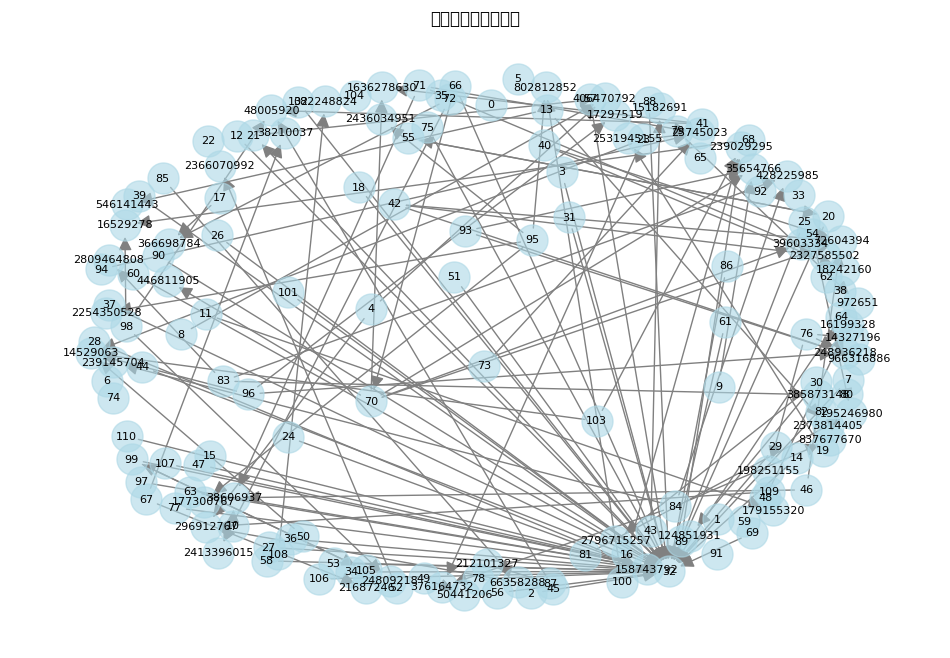

In [76]:
# 分析关注关系
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
print(follow_table.columns)

# 将user之间的关注关系绘制为图
import networkx as nx
import matplotlib.pyplot as plt

# 创建有向图
G = nx.DiGraph()

# 添加节点
for index, row in user_table.iterrows():
    user_id = row['user_id']
    G.add_node(user_id)

# 添加边 
for index, row in follow_table.iterrows():
    follower_id = row['follower_id']
    followee_id = row['followee_id']
    G.add_edge(follower_id, followee_id)

# 绘制有向图
plt.figure(figsize=(12, 8))  # 设置图形大小

# 使用spring_layout布局算法,增加节点间距
pos = nx.spring_layout(G, k=1, iterations=50)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=500, alpha=0.6)

# 绘制边
nx.draw_networkx_edges(G, pos, edge_color='gray',
                      arrows=True, arrowsize=20)

# 添加标签,调整字体大小和位置
nx.draw_networkx_labels(G, pos, font_size=8,
                       font_family='sans-serif')

plt.title("用户关注关系网络图")
plt.axis('off')  # 关闭坐标轴
plt.show()


Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')


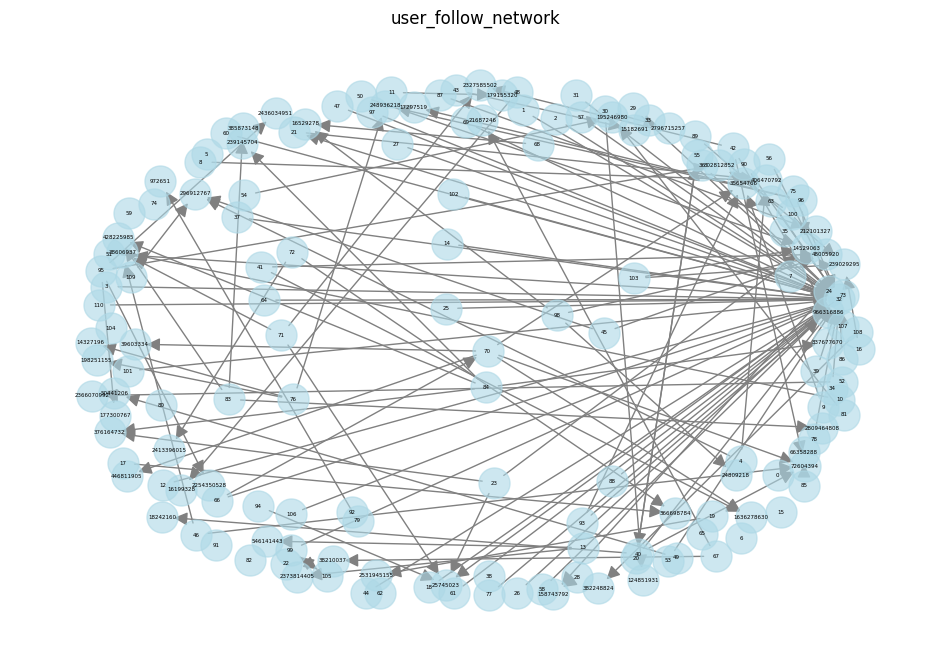

In [79]:
# 分析关注关系
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
print(follow_table.columns)

# 将user之间的关注关系绘制为图
import networkx as nx
import matplotlib.pyplot as plt

# 创建有向图
G = nx.DiGraph()

# 添加节点
for index, row in user_table.iterrows():
    user_id = row['user_id']
    G.add_node(user_id)

# 添加边 
for index, row in follow_table.iterrows():
    follower_id = row['follower_id']
    followee_id = row['followee_id']
    G.add_edge(follower_id, followee_id)

# 绘制有向图
plt.figure(figsize=(12, 8))  # 设置图形大小

# 使用spring_layout布局算法,增加节点间距
pos = nx.spring_layout(G, k=1, iterations=50)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=500, alpha=0.6)

# 绘制边
nx.draw_networkx_edges(G, pos, edge_color='gray',
                      arrows=True, arrowsize=20)

# 添加标签,调整字体大小和位置
nx.draw_networkx_labels(G, pos, font_size=4,
                       font_family='sans-serif')

plt.title("user_follow_network")
plt.axis('off')  # 关闭坐标轴
plt.show()


#### post数量与like数量 柱形图

{32: ['report: amazon plans to open its first physical store, in new york URL', 'LLMs正在逼近人类社交行为的边界，但还差‘灵魂’！🤖 从生成帖子到模拟互动，它们越来越像我们——但缺乏真正的意识。#AI革命 #社交未来 🚀 了解更多：[URL]', "As a Social Media Strategist, I'm fascinated by AI's role in simulating human emotions online. While LLMs excel at mimicry, they still lack the nuanced empathy that makes real human connections resonate. The future lies in augmenting AI with genuine human creativity, not replacing it. #AIandEmpathy #SocialMediaEvolution", "AI may compose sonnets, but can it comfort a grieving cat with a gentle pat? The soul of social media lies in these irreplaceable human moments—the empathy, the spontaneity, the messy beauty of real connections. Let's keep building a future where AI enhances, but never replaces, the warmth of human touch. #HumanFirstTech #EmpathyOverAlgorithms 🐾😏", "As media strategists, we must champion AI applications that enhance human connection rather than replicate it. The future of AI in social interaction lies i

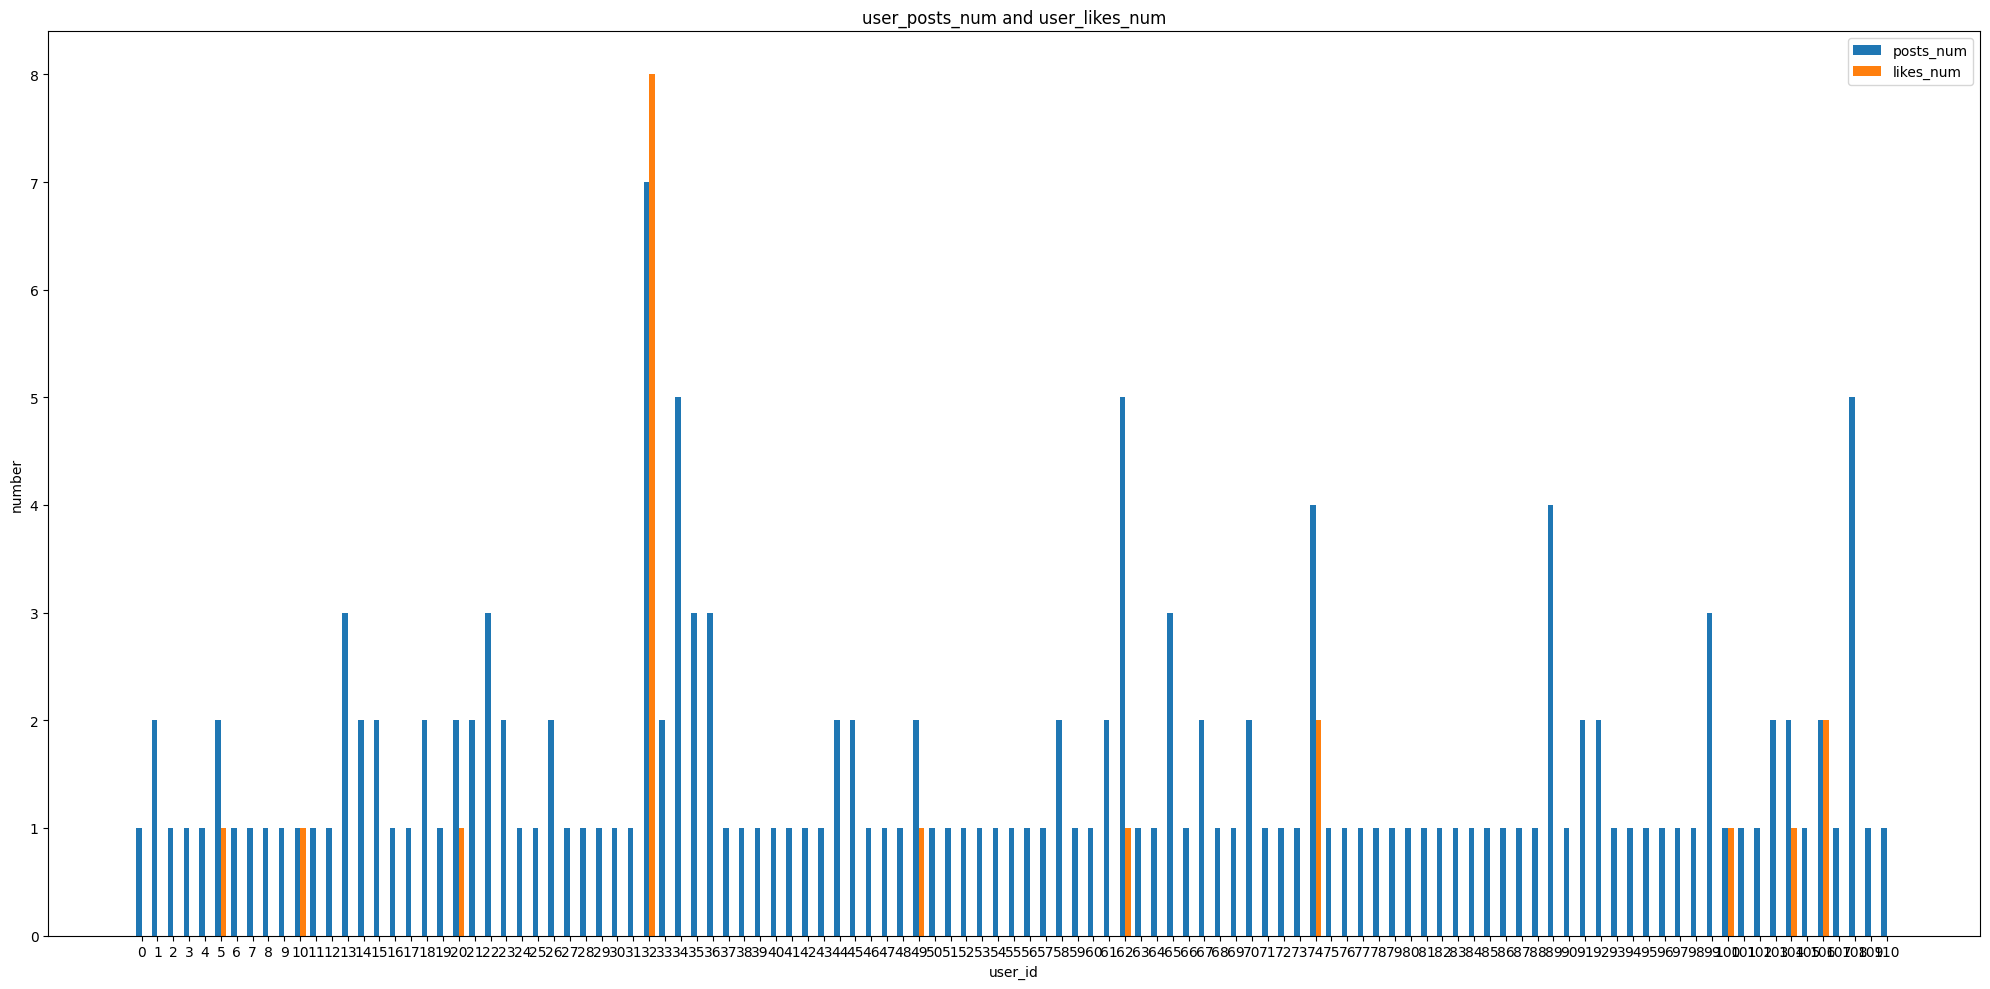

In [68]:
print(user_post_content_map)
import matplotlib.pyplot as plt
import numpy as np

# Count number of posts per user
user_post_counts = {}
for user_id, posts in user_post_content_map.items():
    user_post_counts[user_id] = len(posts)
    
# Count number of likes per user
user_post_like_counts = {}
for user_id, num_likes in user_post_like_map.items():
    if user_id not in user_post_like_counts:
        user_post_like_counts[user_id] = 0
    user_post_like_counts[user_id] += num_likes

# Get all user IDs
all_user_ids = sorted(list(set(list(user_post_counts.keys()) + list(user_post_like_counts.keys()))))

# 设置图形大小
fig, ax = plt.subplots(figsize=(20, 10))

# 设置柱形图的位置
x = np.arange(len(all_user_ids))
width = 0.35  # 柱形的宽度

# 绘制两组柱形图
posts_data = [user_post_counts.get(user_id, 0) for user_id in all_user_ids]
likes_data = [user_post_like_counts.get(user_id, 0) for user_id in all_user_ids]

rects1 = ax.bar(x - width/2, posts_data, width, label='posts_num')
rects2 = ax.bar(x + width/2, likes_data, width, label='likes_num')

# 添加标签和标题
ax.set_xlabel('user_id')
ax.set_ylabel('number')
ax.set_title('user_posts_num and user_likes_num')
ax.set_xticks(x)
ax.set_xticklabels(all_user_ids)
ax.legend()

# 调整布局
plt.tight_layout()
plt.show()


## 分析这个实验下，每个时间步之后导致的用户某项指标的变化

In [80]:
start_step = 1
end_step = 24

#### 所有用户  发帖数量、评论数量、点赞数量、点踩数量、关注者数量、被关注者数量

In [96]:
user_table = pd.read_sql_query("SELECT * FROM user", conn)
user_nums = len(user_table)
user_ids = user_table['user_id'].tolist()

posts_nums = {}  # {user_id: [posts_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
comments_nums = {}  # {user_id: [comments_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
likes_nums = {}  # {user_id: [likes_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
dislikes_nums = {}  # {user_id: [dislikes_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
followers_nums = {}  # {user_id: [followers_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
followees_nums = {}  # {user_id: [followees_nums for step in range(start_step, end_step)] for _ in range(user_nums)}

# user_post_content_map = {}
# user_post_like_map = {}
# # 遍历post表，将user_id作为key, 找到其所有的posts，并将post表中的content、num_likes存储到user_posts_map中
# for index, row in post_table.iterrows():
#     user_id = row['user_id']
#     content = row['content']
#     if user_id not in user_post_content_map:
#         user_post_content_map[user_id] = []
#     user_post_content_map[user_id].append(content)
#     num_likes = row['num_likes']
#     if user_id not in user_post_like_map:
#         user_post_like_map[user_id] = 0
#     user_post_like_map[user_id] += num_likes

step_list = []
for db_backup in db_backups:
    try:
        step_index = int(db_backup.split("_")[-1].split(".")[0])
        step_list.append(step_index)
    except:
        continue

step_list.sort()
for step in range(len(db_backups)):
    step_index = int(db_backups[step].split("_")[-1].split(".")[0])
    if step_index not in range(start_step, end_step):
        continue
    step_db = db_backups[step]
    conn = sqlite3.connect(step_db)
    user_table = pd.read_sql_query("SELECT * FROM user", conn)
    post_table = pd.read_sql_query("SELECT * FROM post", conn)
    follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
    like_table = pd.read_sql_query("SELECT * FROM like", conn)
    dislike_table = pd.read_sql_query("SELECT * FROM dislike", conn)

    user_post_content_map = {}
    user_post_like_map = {}
    user_post_dislike_map = {}
    user_ee2followers_map = {}  # [followee_id: [followers_id]]
    user_er2followees_map = {}  # [follower_id: [followees_id]]
    for index, row in post_table.iterrows():
        user_id = row['user_id']
        content = row['content']
        if user_id not in user_post_content_map:
            user_post_content_map[user_id] = []
        user_post_content_map[user_id].append(content)
        num_likes = row['num_likes']
        if user_id not in user_post_like_map:
            user_post_like_map[user_id] = 0
        user_post_like_map[user_id] += num_likes
        num_dislikes = row['num_dislikes']
        if user_id not in user_post_dislike_map:
            user_post_dislike_map[user_id] = 0
        user_post_dislike_map[user_id] += num_dislikes
    for index, row in follow_table.iterrows():
        follower_id = int(row['follower_id'])
        followee_id = int(row['followee_id'])
        # 检查followee_id而不是follower_id
        if followee_id not in user_ee2followers_map:
            user_ee2followers_map[followee_id] = []
        user_ee2followers_map[followee_id].append(follower_id)
        if follower_id not in user_er2followees_map:
            user_er2followees_map[follower_id] = []
        user_er2followees_map[follower_id].append(followee_id)

    for user_id in user_table['user_id']:
        # 初始化字典如果用户ID不存在
        if user_id not in posts_nums:
            posts_nums[user_id] = []
        if user_id not in comments_nums:
            comments_nums[user_id] = []
        if user_id not in likes_nums:
            likes_nums[user_id] = []
        if user_id not in dislikes_nums:
            dislikes_nums[user_id] = []
        if user_id not in followers_nums:
            followers_nums[user_id] = []
        if user_id not in followees_nums:
            followees_nums[user_id] = []
            
        # 获取用户数据,如果不存在则使用默认值0
        post_count = len(user_post_content_map.get(user_id, []))
        like_count = user_post_like_map.get(user_id, 0)
        dislike_count = user_post_dislike_map.get(user_id, 0)
        follower_count = len(user_ee2followers_map.get(user_id, []))
        followee_count = len(user_er2followees_map.get(user_id, []))
        
        # 添加数据到对应列表
        posts_nums[user_id].append(post_count)
        comments_nums[user_id].append(like_count)
        likes_nums[user_id].append(like_count)
        dislikes_nums[user_id].append(dislike_count)
        followers_nums[user_id].append(follower_count)
        followees_nums[user_id].append(followee_count)

import matplotlib.pyplot as plt
import numpy as np

# 设置图形大小
fig, ax = plt.subplots(figsize=(20, 10))

# 将posts_nums、comments_nums、likes_nums、dislikes_nums、followers_nums、followees_nums绘制成折线图
for user_id in user_ids:
    ax.plot(range(start_step, end_step), posts_nums[user_id], label='posts_num')
    ax.plot(range(start_step, end_step), comments_nums[user_id], label='comments_num')
    ax.plot(range(start_step, end_step), likes_nums[user_id], label='likes_num')
    ax.plot(range(start_step, end_step), dislikes_nums[user_id], label='dislikes_num')
    ax.plot(range(start_step, end_step), followers_nums[user_id], label='followers_num')
    ax.plot(range(start_step, end_step), followees_nums[user_id], label='followees_num')

# 添加标签和标题
ax.set_xlabel('step')
ax.set_ylabel('number')
ax.set_title('user_posts_num and user_likes_num')
ax.set_xticks(x)

fig.show()



ValueError: invalid literal for int() with base 10: 'Done'